In [1]:
import sys
import os
import glob
import json
import pandas as pd
%matplotlib inline
import matplotlib
import numpy as np

In [2]:
def find_files(path):
    return glob.glob(path)

In [3]:
def read_json(filename):
    with open(filename) as json_file:
        data = json.load(json_file)
    return data

## Adatok olvasása
Adatok beolvasása JSON fájlként, majd egy nagy pandas-os DataFrame-mé alakítása.

In [4]:
json_data = []

for file in find_files('Data/*'):
    print("Reading file:", file)
    json_data.append(read_json(file))
    
data_frame = pd.DataFrame()

for data in json_data:
    frames  = [data_frame, pd.DataFrame(data)]
    data_frame = pd.concat(frames).reset_index(drop=True)

Reading file: Data/gyakori_szorakozas_30000
Reading file: Data/gyakori_allatok_14000
Reading file: Data/gyakori_egeszseg
Reading file: Data/gyakori_egeszseg_20000
Reading file: Data/gyakori_szamitastechnika


## Bepillantás a kérdésekbe
Csak hogy tudjuk pontosan mivel is állunk szemben. Minden kérdéshez tartozik a kérdés rövid, illetve hosszú verziója, egy válasz, amit a felhasználók a leghasznosabbnak találtak. Ezeken kívül kategóriák és kulcsszavak is vannak a kérdéshez.

In [5]:
data_frame.head(2)

,kategoriak,hosszu_kerdes,rovid_kerdes,keywords,valasz
0,"[Szórakozás, Filmek, sorozatok]",Milyen animék vannak amikben a tanulás szerepe...,Milyen animék vannak amikben a tanulás szerepe...,"[rész, tanulás, iskola, anime]",Baka To TestAnsatsu KyoushitsuBokutachi wa Ben...
1,"[Szórakozás, Filmek, sorozatok]",Nem látta már valaki véletlen ezt a filmet? Ez...,Nem látta már valaki véletlen ezt a filmet? Ez...,"[Tumblr, film, gif, mozgókép, csók]","Nagyon ügyes a barátod, én is szoktam vele bes..."


A kategóriák közül csak a "főkategória" lényeges számunka, ezért a többit elhagyjuk.

In [6]:
data_frame['kategoriak'] = data_frame['kategoriak'].apply(lambda x: x[0])

## Átlagos hossz, extrém esetek szűrése
Az extrém hosszú vagy rövid kérdések nem túl hasznosak. Érdemes őket kiszűrni. Az átlagostól sokkal eltérő kérdéseket nem használjuk a továbbiakban.

In [7]:
def calculate_avg(data_frame, label="rovid_kerdes"):
    l = data_frame[label].tolist()
    return sum(map(len, l)) / len(l)

def drop_extreme(data_frame, min_, max_, label="rovid_kerdes"):
    data_frame = data_frame[data_frame[label].map(len) >= min_]
    data_frame = data_frame[data_frame[label].map(len) <= max_]

    return data_frame

In [8]:
long_questions_avg_len = calculate_avg(data_frame, "hosszu_kerdes")
print("Average length: %f" % long_questions_avg_len)

Average length: 346.495816


In [9]:
data_frame = drop_extreme(data_frame, long_questions_avg_len / 4, long_questions_avg_len * 3, "hosszu_kerdes")
long_questions_avg_len = calculate_avg(data_frame, "hosszu_kerdes")

print("Average length: %f" % long_questions_avg_len)

Average length: 326.753950


## "Főkategóriák" kigyűjtése
Az egyes főkategóriák neveinek kigyűjtése, majd az egyes nevekhez egy azonosító szám rendelése.

In [10]:
target_names = data_frame['kategoriak'].unique().tolist()
target_dict =  {value: key for key, value in enumerate(target_names)}

num_of_categories = len(target_names)

print(target_names)
print(target_dict)

['Szórakozás', 'Állatok', 'Egészség', 'Számítástechnika']
{'Szórakozás': 0, 'Állatok': 1, 'Egészség': 2, 'Számítástechnika': 3}


## Tanító adathalmaz előállítása
A tanító adathalmazban minden egyes főkategóriából ugyanannyi kérdésnek kell szerepelnie (így fair). Itt pontosan ez történik `questions_from_each_category` darab kérdés kerül a tanító adathalmazba minden kategóriából, majd az eredményül kapott tömb véletlenszerűen összekeveredik.

#### Shuffle together
A shuffle_together függvény két listát véletlenszerűen kever össze, úgy, hogy az a keverés előtt az egyes listákban azonos indexen szereplő értékek a keverés után is azonos indexen lesznek.

In [11]:
def shuffle_together(list1, list2):
    zipped = list(zip(list1, list2))
    random.shuffle(zipped)
    list1, list2 = zip(*zipped)
    
    return (list(list1), list(list2))

In [12]:
import random

train_each_ctg = 2100
train_size = train_each_ctg * num_of_categories
train_questions = []
train_target = []

test_each_ctg = 1200
test_size = test_each_ctg * num_of_categories
test_questions = []
test_target = []

# Shuffle rows
data_frame = data_frame.sample(frac=1).reset_index(drop=True)

for target_name in target_names:
    train_questions += data_frame[data_frame["kategoriak"] == target_name][0:train_each_ctg]["hosszu_kerdes"].to_list()
    train_target += [target_dict[target_name]] * train_each_ctg    
    
    test_questions += data_frame[data_frame["kategoriak"] == target_name][train_each_ctg:train_each_ctg + test_each_ctg]["hosszu_kerdes"].to_list()
    test_target += [target_dict[target_name]] * test_each_ctg    

train_questions, train_target = shuffle_together(train_questions, train_target)
test_questions, test_target = shuffle_together(test_questions, test_target)

In [52]:
def unicode_to_ascii(data):
    return unidecode.unidecode(re.sub(r"[,.;@#?!&$]+\ *", " ", data).lower()).split()

In [53]:
def generate_ngrams(data, n):
    return [(data[i:i + n]) for i in range(len(data) - n + 1)]

In [54]:
import unidecode
import re
from collections import Counter

unigrams = set()
bigrams = set()

for idx, q in enumerate(train_questions):
    words = unicode_to_ascii(q)

    for word in words:
        vocab.add(word)

    train_questions[idx] = " ".join(words)  

    unigrams.update(generate_ngrams(words, 1))
    bigrams.update(generate_ngrams(words, 2))

unigram_size = len(unigram)

index_to_unigram = {}
index_to_bigram = {}

for idx, unigram in enumerate(unigrams):
    index_to_unigram[unigram] = idx
    
for idx, bigram in enumerate(bigrams):
    index_to_bigram[bigram] = idx;

TypeError: unhashable type: 'list'

In [47]:
def get_batch(text, target=[0], i=0, batch_size=1):

    batches = []
    results = []
    
    texts = text[i * batch_size : i * batch_size + batch_size]
    categories = target[i * batch_size : i * batch_size + batch_size]

    for text in texts:
        layer = np.zeros(input_size , dtype=float)
        for word in text.split():
            if word.lower() in index_of_word:
                layer[index_of_word[word.lower()]] += 1
            
        batches.append(layer)
        
    for category in categories:
        results.append(category)
     
    return np.array(batches), np.array(results)

In [48]:
learning_rate = 0.01
num_epochs = 5
batch_size = 150

hidden_size = 100
input_size = total_words
num_classes = len(target_names)

In [17]:
from torch.autograd import Variable
import torch.nn as nn
import torch

In [18]:
class BagOfWordsModel(nn.Module):
     def __init__(self, input_size, hidden_size, num_classes):
        super(Classification, self).__init__()
        self.relu = nn.ReLU()
        self.layer_1 = nn.Linear(input_size, hidden_size, bias=True)
        self.layer_2 = nn.Linear(hidden_size, hidden_size, bias=True)
        self.output_layer = nn.Linear(hidden_size, num_classes, bias=True)
 
     def forward(self, x):
        out = self.layer_1(x)
        out = self.relu(out)
        out = self.layer_2(out)
        out = self.relu(out)
        out = self.output_layer(out)
        return out

class NGramModel(nn.Module):
    def __init_(self, vocab_size, embed_dim, num_class):
        self.relu = nn.ReLU()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.linear = nn.Linear(embed_dim, num_class)
    
    def forward(self, text, offsets):
        emb = self.embedding(text, offsets)
        out = self.linear(emb)
        return out

In [19]:
net = Classification(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()  
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)  


for epoch in range(num_epochs):
    if epoch:
        print()
    print("Epoch %d/%d: " % (epoch + 1, num_epochs))
    total_batch = len(train_questions) // batch_size
    for i in range(total_batch):
        batch_x, batch_y = get_batch(train_questions, train_target, i, batch_size)
        questions = Variable(torch.FloatTensor(batch_x))
        themes = Variable(torch.LongTensor(batch_y))
        
        optimizer.zero_grad()
        outputs = net(questions)
        loss = criterion(outputs, themes)
        loss.backward()
        optimizer.step()
        
        print("\r[%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")

Epoch 1/5: 


/home/versenyi/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


[56/56] 100.00%
Epoch 2/5: 
[56/56] 100.00%
Epoch 3/5: 
[56/56] 100.00%
Epoch 4/5: 
[56/56] 100.00%
Epoch 5/5: 
[56/56] 100.00%

In [20]:
total_batch = test_size // batch_size

total = 0
correct = 0
total_pred = []

for i in range(total_batch):
    test_batch_x, test_batch_y = get_batch(test_questions, test_target, i, batch_size)
    print("\rTesting... [%d/%d] %.2f%%" % (i + 1, total_batch, (i + 1)/ total_batch * 100), end="")
    
    questions = Variable(torch.FloatTensor(test_batch_x))
    themes = Variable(torch.FloatTensor(test_batch_y))
    
    outputs = net(questions)
    _, predicted = torch.max(outputs.data, 1)
    total_pred += predicted.tolist()
    correct += (predicted == themes).sum().item()
    total += len(themes)

Testing... [32/32] 100.00%

## Tesztelés eredémye

### Confusion matrix
Tévesztési mátrix magyarul. A mátrix `i` sorában, `j` oszlopában szereplő érték (ebben az esetben) azt jelenti, hogy a mondat a `i` kategóriájú, de a háló `j` kategóriát ismert fel.

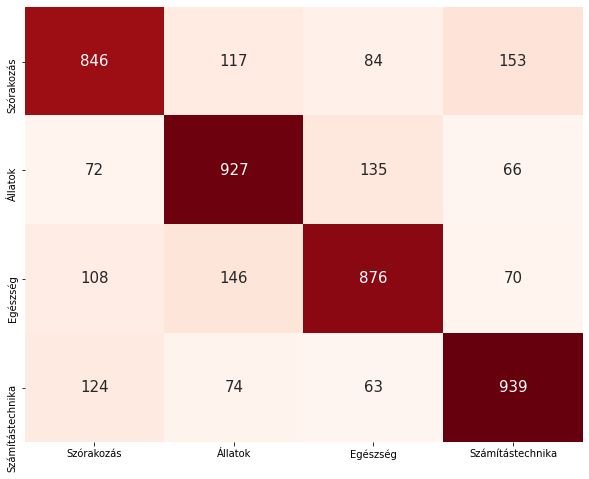

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

cm = confusion_matrix(test_target, total_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

plt.figure(figsize = (10,8))
heatmap = sn.heatmap(cm_df, annot=True, cmap='Reds', fmt='g', annot_kws={"size": 15}, cbar=False)
plt.show()

## Classification report
### Accuracy
A accuracy érték jelentése: a kérdések mekkora részét sikerült helyesen osztályozni.
### Precision
A Szórakozás kategóriához tartozó precision érték azt jelenti, hogy az összes Szórakozás kategóriába sorolt kérdés közül mekkora arányban vannak a ténylegesen Szórakozás kategóriájú kérdések.
### Recall
A recall érték a precision értékhez eléggé hasonló. Az összes ténylegesen Szórakozás kategóriájú kérdés mekkora részét sorolta Szórakozás kategóriába az osztályozó.

In [22]:
from sklearn.metrics import classification_report

class_report = classification_report(test_target, total_pred, target_names=target_names)
print(class_report)

                  precision    recall  f1-score   support

      Szórakozás       0.74      0.70      0.72      1200
         Állatok       0.73      0.77      0.75      1200
        Egészség       0.76      0.73      0.74      1200
Számítástechnika       0.76      0.78      0.77      1200

        accuracy                           0.75      4800
       macro avg       0.75      0.75      0.75      4800
    weighted avg       0.75      0.75      0.75      4800



In [23]:
print("Mennyi kérdésed van?")
q_num = int(input())

for q in range(q_num):
    test_text = input()

    test_data = unicode_to_ascii(test_text)

    batch_x_test, _ = get_batch(test_data)
    question = Variable(torch.FloatTensor(batch_x_test))
    outputs = net(question)
    _, predicted = torch.max(outputs.data, 1)

    print("A kérdés %s témájú .. talán." % target_names[predicted.item()])

Mennyi kérdésed van?


KeyboardInterrupt: Interrupted by user